In [263]:
import numpy as np
import random
import io
import pickle
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from keras.utils import to_categorical
from tensorflow.keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding

In [264]:
RANDOM_STATE = 23

Downloading dataset: https://www.kaggle.com/datasets/nicapotato/womens-ecommerce-clothing-reviews

In [265]:
import os
import gdown

if os.access('clothing_ecommerce_reviews.csv', os.F_OK) is False:
    url = 'https://drive.google.com/uc?id=1Urn1UFSrodN5BuW6-sc_igtaySGRwhV8'
    output = 'clothing_ecommerce_reviews.csv'
    gdown.download(url, output, quiet=False)
else:
    print("Dataset already downloaded")

Dataset already downloaded


In [266]:
df = pd.read_csv('clothing_ecommerce_reviews.csv')
df.drop(columns = ['Unnamed: 0'], inplace = True)
df.head()

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


Pre-processing

In [267]:
df_reviews = df.loc[:, ['Review Text', 'Rating']].dropna()
df_reviews['Rating'] = df_reviews['Rating'] - 1
df_reviews.head()

,Review Text,Rating
0,Absolutely wonderful - silky and sexy and comf...,3
1,Love this dress! it's sooo pretty. i happene...,4
2,I had such high hopes for this dress and reall...,2
3,"I love, love, love this jumpsuit. it's fun, fl...",4
4,This shirt is very flattering to all due to th...,4


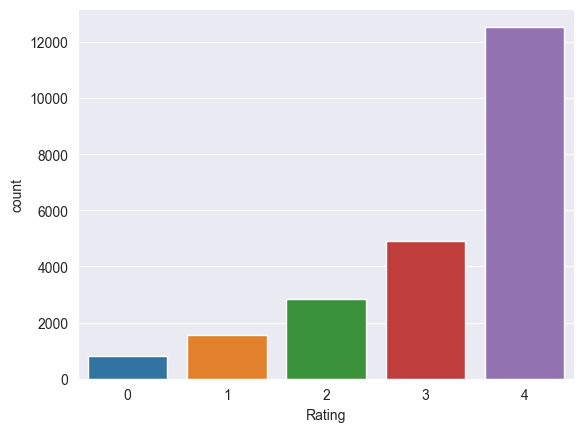

In [268]:
sns.countplot(x='Rating', data=df_reviews)
plt.show()

In [269]:
X = df_reviews['Review Text'].values.reshape(-1, 1)
y = df_reviews['Rating']

In [270]:
from imblearn.under_sampling import RandomUnderSampler

undersample = RandomUnderSampler(sampling_strategy='not minority', random_state=RANDOM_STATE)
X_res, y_res = undersample.fit_resample(X, y)

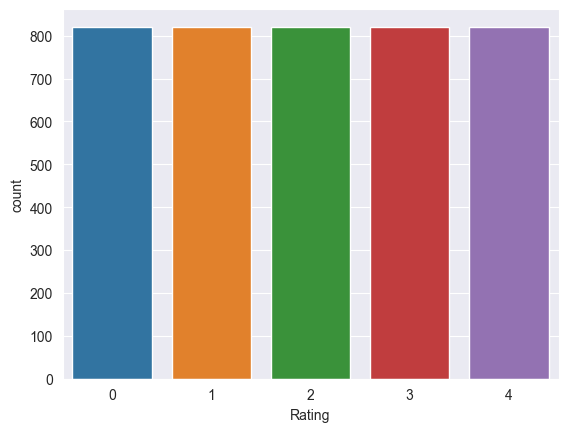

In [271]:
sns.countplot(x='Rating', data=y_res.to_frame())
plt.show()

In [272]:
reviews_array = X_res.ravel()

In [273]:
reviews_array[0:5]

array(["3 tags sewn in, 2 small (about 1'' long) and 1 huge (about 2'' x 3''). very itchy so i cut them out. then the thread left behind was plasticy and even more itchy! how can you make an intimates item with such itchy tags? not comfortable at all! also - i love bralettes and wear them all the time including to work. i am a b cup. however, this one is so thin and flimsy that it gives no support even to a b cup - so for me this would only be a lounging bralette - if it wasn't so itchy!",
       'I was really hoping to like this, but it did not look the way it does on the model, at least not on me. the sharkbite hem is much more pronounced and looser. the one in the photo looks like it was pinned back. i am 5\'8" and usually wear a medium or large. i got a medium and there was a lot more material on the bottom half than the photo shows. it made me look bigger and was not flattering. material has a nice weave but it\'s thin and delicate. i bought the (holly) deep olive and the blue. co

In [274]:
len(reviews_array)

4105

In [275]:
type(reviews_array)

numpy.ndarray

In [276]:
import re
import unicodedata
from keras.src.preprocessing.text import text_to_word_sequence

pattern = r'[^a-zA-z0-9.,!?/:;\"\'\s]'
sentence_tokens = []
for sentence in reviews_array:
    ttw = text_to_word_sequence(sentence)
    ttw_processed = []
    for word in ttw:
        word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        word = re.sub(pattern, '', word)
        ttw_processed.append(word)
    sentence_tokens.append(ttw_processed)

In [277]:
sentence_tokens[0:2]

[['3',
  'tags',
  'sewn',
  'in',
  '2',
  'small',
  'about',
  "1''",
  'long',
  'and',
  '1',
  'huge',
  'about',
  "2''",
  'x',
  "3''",
  'very',
  'itchy',
  'so',
  'i',
  'cut',
  'them',
  'out',
  'then',
  'the',
  'thread',
  'left',
  'behind',
  'was',
  'plasticy',
  'and',
  'even',
  'more',
  'itchy',
  'how',
  'can',
  'you',
  'make',
  'an',
  'intimates',
  'item',
  'with',
  'such',
  'itchy',
  'tags',
  'not',
  'comfortable',
  'at',
  'all',
  'also',
  'i',
  'love',
  'bralettes',
  'and',
  'wear',
  'them',
  'all',
  'the',
  'time',
  'including',
  'to',
  'work',
  'i',
  'am',
  'a',
  'b',
  'cup',
  'however',
  'this',
  'one',
  'is',
  'so',
  'thin',
  'and',
  'flimsy',
  'that',
  'it',
  'gives',
  'no',
  'support',
  'even',
  'to',
  'a',
  'b',
  'cup',
  'so',
  'for',
  'me',
  'this',
  'would',
  'only',
  'be',
  'a',
  'lounging',
  'bralette',
  'if',
  'it',
  "wasn't",
  'so',
  'itchy'],
 ['i',
  'was',
  'really',
  'hop

In [278]:
distinct_tokens = []
for sentence in sentence_tokens:
    for token in sentence:
        if token not in distinct_tokens:
            distinct_tokens.append(token)

In [279]:
len(distinct_tokens)

7272

In [280]:
from keras.preprocessing.text import Tokenizer

num_words = 2000
vocab_size = num_words

tok = Tokenizer(num_words)
tok.fit_on_texts(sentence_tokens)
sequences = tok.texts_to_sequences(sentence_tokens)

In [281]:
sequences[:20]

[[393,
  1707,
  597,
  9,
  169,
  43,
  125,
  101,
  3,
  463,
  200,
  125,
  1153,
  23,
  482,
  16,
  2,
  106,
  79,
  55,
  197,
  1,
  741,
  683,
  1118,
  11,
  3,
  75,
  56,
  482,
  187,
  105,
  41,
  202,
  57,
  464,
  19,
  307,
  482,
  1707,
  15,
  122,
  39,
  66,
  70,
  2,
  34,
  3,
  40,
  79,
  66,
  1,
  191,
  1505,
  8,
  107,
  2,
  38,
  5,
  598,
  628,
  110,
  7,
  54,
  6,
  16,
  146,
  3,
  866,
  20,
  4,
  977,
  112,
  1119,
  75,
  8,
  5,
  598,
  628,
  16,
  14,
  26,
  7,
  32,
  131,
  28,
  5,
  1962,
  45,
  4,
  240,
  16,
  482],
 [2,
  11,
  47,
  399,
  8,
  22,
  7,
  10,
  4,
  113,
  15,
  49,
  1,
  77,
  4,
  157,
  12,
  1,
  127,
  39,
  400,
  15,
  12,
  26,
  1,
  394,
  6,
  63,
  56,
  3,
  785,
  1,
  54,
  9,
  1,
  206,
  62,
  22,
  4,
  11,
  1084,
  51,
  2,
  38,
  523,
  3,
  136,
  40,
  5,
  116,
  44,
  64,
  2,
  103,
  5,
  116,
  3,
  98,
  11,
  5,
  241,
  56,
  58,
  12,
  1,
  170,
  509,
  69,
  1,
  2

In [282]:
print(tok.word_index)

{'the': 1, 'i': 2, 'and': 3, 'it': 4, 'a': 5, 'is': 6, 'this': 7, 'to': 8, 'in': 9, 'but': 10, 'was': 11, 'on': 12, 'of': 13, 'for': 14, 'not': 15, 'so': 16, 'my': 17, 'dress': 18, 'with': 19, 'that': 20, 'have': 21, 'like': 22, 'very': 23, 'size': 24, 'top': 25, 'me': 26, 'fit': 27, 'be': 28, 'too': 29, 'are': 30, 'as': 31, 'would': 32, 'just': 33, 'love': 34, "it's": 35, 'fabric': 36, "i'm": 37, 'am': 38, 'at': 39, 'wear': 40, 'you': 41, 'they': 42, 'small': 43, 'or': 44, 'if': 45, 'up': 46, 'really': 47, 'ordered': 48, 'look': 49, 'color': 50, 'back': 51, 'great': 52, 'had': 53, 'one': 54, 'out': 55, 'more': 56, 'an': 57, 'material': 58, 'when': 59, 'shirt': 60, 'because': 61, 'looks': 62, 'much': 63, 'large': 64, '\r': 65, 'all': 66, 'will': 67, 'these': 68, 'than': 69, 'also': 70, 'cute': 71, 'little': 72, 'flattering': 73, 'well': 74, 'even': 75, 'beautiful': 76, 'way': 77, 'down': 78, 'them': 79, 'nice': 80, 'quality': 81, 'were': 82, 'which': 83, 'waist': 84, 'made': 85, 'soft'

In [283]:
sentence_tokens_as_numbers = []

for sentence in sentence_tokens:
    sentence_as_num = []
    for token in sentence:
        sentence_as_num.append(tok.word_index[token])
    sentence_tokens_as_numbers.append(sentence_as_num)

In [284]:
len(max(sentence_tokens_as_numbers, key=len))

112

In [285]:
max_length_sentence_index = sentence_tokens_as_numbers.index(max(sentence_tokens_as_numbers, key=len))
max_length_sentence_index

215

In [286]:
sentence_tokens[max_length_sentence_index]

['i',
 'wanted',
 'to',
 'love',
 'this',
 'blouse',
 'so',
 'much',
 'but',
 'try',
 'as',
 'i',
 'might',
 'it',
 'just',
 'fit',
 'so',
 'oddly',
 'on',
 'me',
 "i'm",
 'usually',
 'a',
 'petite',
 's',
 'so',
 'i',
 'purchased',
 'the',
 'xs',
 'in',
 'brown',
 'first',
 'the',
 'color',
 'was',
 'more',
 'gray',
 'brown',
 'but',
 'it',
 'was',
 'still',
 'ok',
 'but',
 'second',
 'the',
 'fit',
 'was',
 'off',
 'maybe',
 'i',
 'just',
 'got',
 'a',
 'bad',
 'one',
 'but',
 'the',
 'center',
 'of',
 'the',
 'blouse',
 'was',
 'so',
 'offset',
 'that',
 'the',
 'slit',
 'in',
 'the',
 'front',
 'laid',
 'so',
 'far',
 'to',
 'the',
 'left',
 'and',
 'the',
 'v',
 'neck',
 'was',
 'so',
 'low',
 'that',
 'you',
 'could',
 'see',
 'my',
 'bra',
 'there',
 'was',
 'no',
 'adjusting',
 'i',
 'could',
 'do',
 'to',
 'fix',
 'it',
 'the',
 'material',
 'has',
 'a',
 'lovely',
 'soft',
 'silky',
 'feel',
 'to',
 'it',
 'an']

In [287]:
len(sentence_tokens[max_length_sentence_index])

112

In [288]:
from keras.utils import pad_sequences
maxlen = len(sentence_tokens[max_length_sentence_index])

X_pad = pad_sequences(sequences, padding='pre', maxlen=maxlen)

In [289]:
y_res

0       0
1       0
2       0
3       0
4       0
       ..
4100    4
4101    4
4102    4
4103    4
4104    4
Name: Rating, Length: 4105, dtype: int64

In [290]:
X = X_pad
y = pd.get_dummies(y_res, columns = ['Remarks', 'Gender'])

In [291]:
X.shape

(4105, 112)

In [292]:
y.shape

(4105, 5)

In [293]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y,random_state=RANDOM_STATE, shuffle=True)

In [294]:
in_shape = X_train.shape[1]
out_shape = 5
print("in_shape", in_shape, ", out_shape", out_shape)

in_shape 112 , out_shape 5


Training without pre-trained embeddings

In [303]:
from keras.layers import LSTM, Embedding, Dropout

model = Sequential()
model.add(Embedding(input_dim=vocab_size + 1, output_dim=100, input_length=in_shape))

model.add((LSTM(units=64, return_sequences=True, kernel_regularizer=keras.regularizers.l2(0.001))))
model.add(Dropout(0.3))

model.add((LSTM(units=64, kernel_regularizer=keras.regularizers.l2(0.001))))
model.add(Dropout(0.3))

model.add(Dense(units=128, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)))
model.add(Dropout(0.3))

model.add(Dense(units=out_shape, activation='softmax'))

optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_43"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_43 (Embedding)    (None, 112, 100)          200100    
                                                                 
 lstm_81 (LSTM)              (None, 112, 64)           42240     
                                                                 
 dropout_75 (Dropout)        (None, 112, 64)           0         
                                                                 
 lstm_82 (LSTM)              (None, 64)                33024     
                                                                 
 dropout_76 (Dropout)        (None, 64)                0         
                                                                 
 dense_77 (Dense)            (None, 128)               8320      
                                                                 
 dropout_77 (Dropout)        (None, 128)             

In [304]:
hist = model.fit(X_train, y_train, epochs=20, batch_size=128,validation_split=0.2)

Epoch 1/20
21/21 [==============================] - 11s 389ms/step - loss: 1.8805 - accuracy: 0.2101 - val_loss: 1.8205 - val_accuracy: 0.2040
Epoch 2/20
21/21 [==============================] - 8s 365ms/step - loss: 1.7469 - accuracy: 0.2908 - val_loss: 1.6265 - val_accuracy: 0.3455
Epoch 3/20
21/21 [==============================] - 8s 365ms/step - loss: 1.4843 - accuracy: 0.3453 - val_loss: 1.4352 - val_accuracy: 0.3607
Epoch 4/20
21/21 [==============================] - 8s 365ms/step - loss: 1.3277 - accuracy: 0.3848 - val_loss: 1.4207 - val_accuracy: 0.4170
Epoch 5/20
21/21 [==============================] - 8s 365ms/step - loss: 1.2297 - accuracy: 0.4416 - val_loss: 1.5387 - val_accuracy: 0.4079
Epoch 6/20
21/21 [==============================] - 8s 366ms/step - loss: 1.1656 - accuracy: 0.4705 - val_loss: 1.5044 - val_accuracy: 0.3957
Epoch 7/20
21/21 [==============================] - 8s 365ms/step - loss: 1.0997 - accuracy: 0.5173 - val_loss: 1.5722 - val_accuracy: 0.4110
Epoch

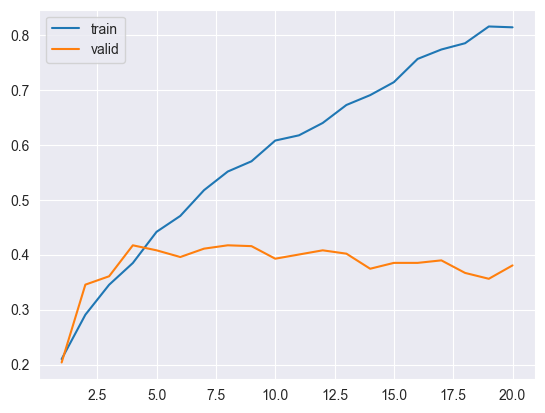

In [305]:
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist.history['val_accuracy'], label='valid')
plt.show()

Tried with different parameters and architectures (adding Bidirectional, recurrent_dropouts, more layers, different units and dropout rates), but was not able to overcome the threshold of 0.4 on the validation accuracy

In [306]:
model.evaluate(X_test, y_test)

26/26 [==============================] - 1s 42ms/step - loss: 2.3898 - accuracy: 0.3825


[2.3897900581359863, 0.38246041536331177]

Training using Fasttext pre-trained embeddings

In [308]:
import os
import gdown

if os.access('fasttext.pkl', os.F_OK) is False:
    url = 'https://drive.google.com/u/0/uc?id=1Qi1r-u5lsEsNqRSxLrpNOqQ3B_ufltCa&export=download&confirm=t'
    output = 'fasttext.pkl'
    gdown.download(url, output, quiet=False)
else:
    print("Dataset already downloaded")

Downloading...
From: https://drive.google.com/u/0/uc?id=1Qi1r-u5lsEsNqRSxLrpNOqQ3B_ufltCa&export=download&confirm=t
To: C:\Users\Usuario\Desktop\Posgrado\Proyectos\NLP\ejercicio5\fasttext.pkl
100%|██████████| 2.88G/2.88G [03:35<00:00, 13.3MB/s]


In [309]:
import logging
import os
from pathlib import Path

In [310]:
class WordsEmbeddings(object):
    logger = logging.getLogger(__name__)

    def __init__(self):
        # load the embeddings
        words_embedding_pkl = Path(self.PKL_PATH)
        if not words_embedding_pkl.is_file():
            words_embedding_txt = Path(self.WORD_TO_VEC_MODEL_TXT_PATH)
            assert words_embedding_txt.is_file(), 'Words embedding not available'
            embeddings = self.convert_model_to_pickle()
        else:
            embeddings = self.load_model_from_pickle()
        self.embeddings = embeddings
        # build the vocabulary hashmap
        index = np.arange(self.embeddings.shape[0])
        # Dicctionarios para traducir de embedding a IDX de la palabra
        self.word2idx = dict(zip(self.embeddings['word'], index))
        self.idx2word = dict(zip(index, self.embeddings['word']))

    def get_words_embeddings(self, words):
        words_idxs = self.words2idxs(words)
        return self.embeddings[words_idxs]['embedding']

    def words2idxs(self, words):
        return np.array([self.word2idx.get(word, -1) for word in words])

    def idxs2words(self, idxs):
        return np.array([self.idx2word.get(idx, '-1') for idx in idxs])

    def load_model_from_pickle(self):
        self.logger.debug(
            'loading words embeddings from pickle {}'.format(
                self.PKL_PATH
            )
        )
        max_bytes = 2**28 - 1 # 256MB
        bytes_in = bytearray(0)
        input_size = os.path.getsize(self.PKL_PATH)
        with open(self.PKL_PATH, 'rb') as f_in:
            for _ in range(0, input_size, max_bytes):
                bytes_in += f_in.read(max_bytes)
        embeddings = pickle.loads(bytes_in)
        self.logger.debug('words embeddings loaded')
        return embeddings

    def convert_model_to_pickle(self):
        # create a numpy strctured array:
        # word     embedding
        # U50      np.float32[]
        # word_1   a, b, c
        # word_2   d, e, f
        # ...
        # word_n   g, h, i
        self.logger.debug(
            'converting and loading words embeddings from text file {}'.format(
                self.WORD_TO_VEC_MODEL_TXT_PATH
            )
        )
        structure = [('word', np.dtype('U' + str(self.WORD_MAX_SIZE))),
                     ('embedding', np.float32, (self.N_FEATURES,))]
        structure = np.dtype(structure)
        # load numpy array from disk using a generator
        with open(self.WORD_TO_VEC_MODEL_TXT_PATH, encoding="utf8") as words_embeddings_txt:
            embeddings_gen = (
                (line.split()[0], line.split()[1:]) for line in words_embeddings_txt
                if len(line.split()[1:]) == self.N_FEATURES
            )
            embeddings = np.fromiter(embeddings_gen, structure)
        # add a null embedding
        null_embedding = np.array(
            [('null_embedding', np.zeros((self.N_FEATURES,), dtype=np.float32))],
            dtype=structure
        )
        embeddings = np.concatenate([embeddings, null_embedding])
        # dump numpy array to disk using pickle
        max_bytes = 2**28 - 1 # # 256MB
        bytes_out = pickle.dumps(embeddings, protocol=pickle.HIGHEST_PROTOCOL)
        with open(self.PKL_PATH, 'wb') as f_out:
            for idx in range(0, len(bytes_out), max_bytes):
                f_out.write(bytes_out[idx:idx+max_bytes])
        self.logger.debug('words embeddings loaded')
        return embeddings


class GloveEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'glove.twitter.27B.50d.txt'
    PKL_PATH = 'gloveembedding.pkl'
    N_FEATURES = 50
    WORD_MAX_SIZE = 60


class FasttextEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'cc.en.300.vec'
    PKL_PATH = 'fasttext.pkl'
    N_FEATURES = 300
    WORD_MAX_SIZE = 60

In [311]:
model_fasttext = FasttextEmbeddings()

In [312]:
print('preparing embedding matrix...')
embed_dim = 300 # fasttext
words_not_found = []

nb_words = min(num_words, len(tok.word_index))
embedding_matrix = np.zeros((nb_words, embed_dim))

for word, i in tok.word_index.items():
    if i >= nb_words:
        continue
    embedding_vector = model_fasttext.get_words_embeddings(word)[0]
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        embedding_matrix[i] = embedding_vector
    else:
        words_not_found.append(word)
        print(word)

print('number of null word embeddings:', np.sum(np.sum(embedding_matrix**2, axis=1) == 0))

preparing embedding matrix...
number of null word embeddings: 2


In [317]:
model2 = Sequential()
model2.add(Embedding(input_dim=vocab_size,
                     output_dim=embed_dim,
                     input_length=in_shape,
                     weights=[embedding_matrix],
                    trainable=False))

model2.add(LSTM(units=64, return_sequences=True))
model2.add(Dropout(0.2))
model2.add(LSTM(units=64))

model2.add(Dense(units=128, activation='relu'))
model2.add(Dropout(rate=0.2))
model2.add(Dense(units=out_shape, activation='softmax'))

model2.compile(optimizer="adam",
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model2.summary()

Model: "sequential_45"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_45 (Embedding)    (None, 112, 300)          600000    
                                                                 
 lstm_85 (LSTM)              (None, 112, 64)           93440     
                                                                 
 dropout_80 (Dropout)        (None, 112, 64)           0         
                                                                 
 lstm_86 (LSTM)              (None, 64)                33024     
                                                                 
 dense_81 (Dense)            (None, 128)               8320      
                                                                 
 dropout_81 (Dropout)        (None, 128)               0         
                                                                 
 dense_82 (Dense)            (None, 5)               

In [318]:
hist2 = model2.fit(X_train, y_train, epochs=10, validation_split=0.2)

Epoch 1/10
83/83 [==============================] - 18s 179ms/step - loss: 1.6152 - accuracy: 0.1900 - val_loss: 1.6136 - val_accuracy: 0.1887
Epoch 2/10
83/83 [==============================] - 14s 174ms/step - loss: 1.6089 - accuracy: 0.2048 - val_loss: 1.6061 - val_accuracy: 0.2009
Epoch 3/10
83/83 [==============================] - 14s 175ms/step - loss: 1.6063 - accuracy: 0.2341 - val_loss: 1.5999 - val_accuracy: 0.2116
Epoch 4/10
83/83 [==============================] - 14s 175ms/step - loss: 1.5890 - accuracy: 0.2611 - val_loss: 1.5833 - val_accuracy: 0.2451
Epoch 5/10
83/83 [==============================] - 15s 175ms/step - loss: 1.5697 - accuracy: 0.2684 - val_loss: 1.5796 - val_accuracy: 0.2679
Epoch 6/10
83/83 [==============================] - 14s 175ms/step - loss: 1.5485 - accuracy: 0.2904 - val_loss: 1.5521 - val_accuracy: 0.2861
Epoch 7/10
83/83 [==============================] - 15s 175ms/step - loss: 1.5312 - accuracy: 0.3129 - val_loss: 1.5428 - val_accuracy: 0.2892

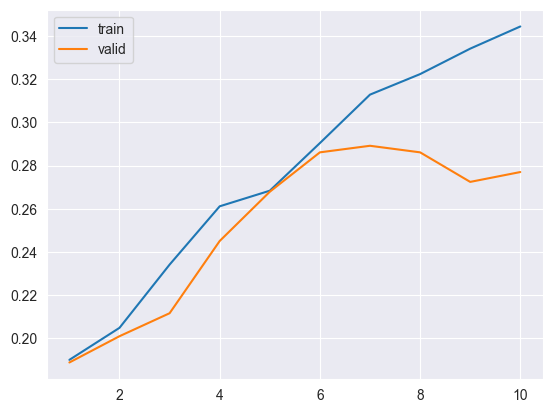

In [319]:
epoch_count = range(1, len(hist2.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist2.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist2.history['val_accuracy'], label='valid')
plt.show()

In [320]:
model2.evaluate(X_test, y_test)

26/26 [==============================] - 2s 77ms/step - loss: 1.5508 - accuracy: 0.2777


[1.5507926940917969, 0.27771010994911194]

The model that used pre trained embeddings ended up with a lower validation accuracy. As explained during the classes, this is not a good option when dealing with sentiment analysis problems.